In [1]:
import math
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from board import Board
from agent import Agent, to_one_hot, bae
from game_utils import get_best_action, evaluate
from collections import deque
# set white background
plt.rcParams['figure.facecolor'] = 'white'
import time

In [2]:
board = Board()

print(board)
print(board.to_tensor().shape, board.get_total_actions())


. % . % 
. % . % 
E P . . 

torch.Size([60]) 23


In [3]:
def train_model(dataset, agent, optimizer, crit, crit2, epochs=5):
    lh = []
    gl = []
    ws = []
    agent.train()
        
    for _ in range(epochs):
        el = []

        for b, m, a, r in DataLoader(dataset, batch_size=32, shuffle=True):      
            
            sla = a.flatten()
            ra = torch.randint_like(sla, 0, 14)
            ri = (r < 0).squeeze(1)
            sla[ri] = ra[ri]
            optimizer.zero_grad()
            pred, pol = agent(b, m)
            l1 = crit(pred, r)
            l2 = crit2(pol, sla)
            loss = l1 + l2
            loss.backward()
            for p in agent.parameters():
                if p.grad is not None:
                    gl.append(p.grad.data.norm(2).item())
                ws.append(p.data.norm(2).item())
            optimizer.step()
            el.append(loss.item())
        lh.append(sum(el) / len(el))
    return lh, gl, ws


def simulate(agent, board_stack, time_step, max_iter, max_depth, max_steps):
    board = Board()
    # board.board = [[0, 3, 0],
    #                [0, 2, 0],
    #                [1, 1, 1]]
    boards = []
    actions = []
    memories = []
    rewards = []
    
    bs = board.to_tensor().unsqueeze(0).repeat(board_stack, 1)
    
    for _ in range(max_steps):
        # if random.random() < 0.1:
        #     a = random.randint(0, board.get_total_actions() - 1)
        # else:
        a, _ = get_best_action(board, bs, agent, timestep=time_step, max_depth=max_depth, max_iter=max_iter)

        bc = board.copy()
        boards.append(bc.to_tensor())
        memories.append(bs)
        actions.append(a)
        board.do_action(a)
        
        be = board.to_tensor().unsqueeze(0)     
        bs = torch.cat([bs[1:], be])
        
        if board.is_win():
            rewards.append(15)
            break

        elif board.board[1][1] == 4 and board.board[0][1] != 3:
            rewards.append(-10)
            break
        else:
            rewards.append(-1)
        
        board.step(time_step)
    
    return boards, memories, actions, rewards
    
    


  0%|          | 0/500 [00:00<?, ?it/s]

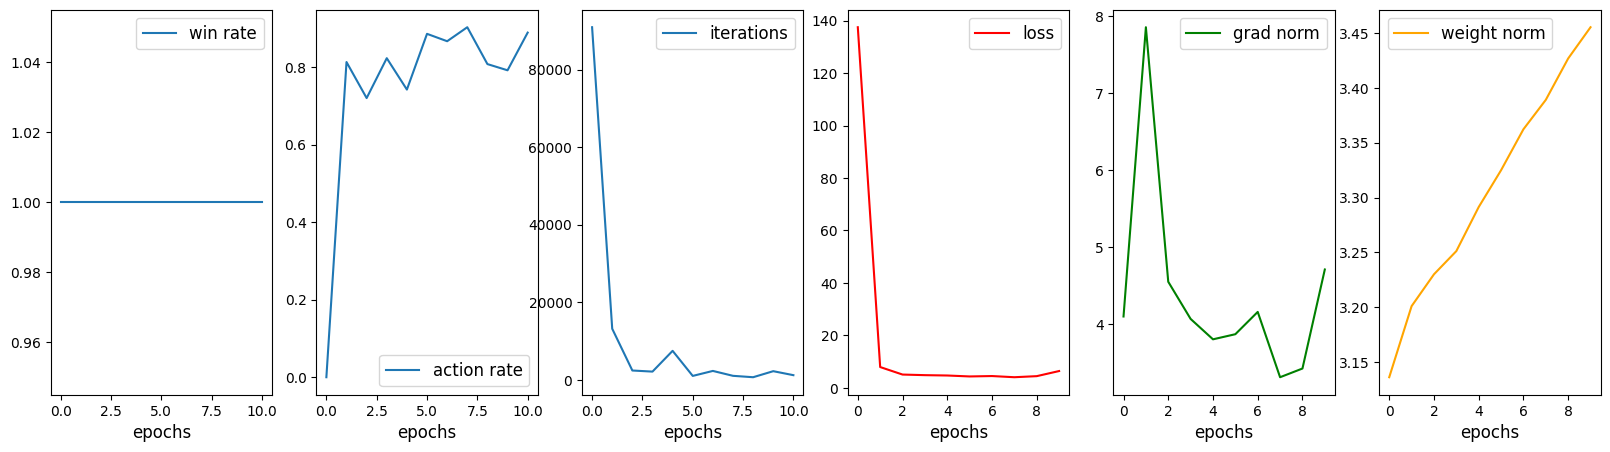

In [4]:
board_stack = 10
time_step = 200
max_iter = 5000
max_depth = 40
max_steps = 40

mem_size = 300
epochs = 500
data_points = 10

ev_runs = 10



agent = Agent(Board().to_tensor().shape[0], 60, Board().get_total_actions(), max_len=board_stack, nhead=4, num_layers=1)
# agent.load_state_dict(torch.load('models/g200.pt'))



optimizer = optim.AdamW(agent.parameters(), lr=0.0001, weight_decay=0.01)
crit = nn.MSELoss()
crit2 = nn.NLLLoss()

boards_memory = deque(maxlen=mem_size)
memories_memory = deque(maxlen=mem_size)
actions_memory = deque(maxlen=mem_size)
rewards_memory = deque(maxlen=mem_size)

best_value = -math.inf
best_it = math.inf
best_act = 0
lh = []
lq = []
gq = []
wq = []
iterations = []
actq = []


for e in tqdm(range(epochs)):

    if e % (epochs / data_points) == 0:
        value, act, its = evaluate(agent, n=ev_runs, use_tree=True, max_steps=max_steps, board_stack=board_stack, timestep=time_step, max_iter=max_iter, max_depth=max_depth)
        if value >= best_value and its <= best_it and act >= best_act:
            best_value = value
            torch.save(agent.state_dict(), 'models/g200.pt')
        lh.append(value)
        actq.append(act)
        iterations.append(its)


    boards, memories, actions, rewards = simulate(agent, board_stack, time_step, max_iter, max_depth, max_steps)
        
    acc_reward = 0
    agent.train()
    for b, m, a, r in reversed(list(zip(boards, memories, actions, rewards))):
        acc_reward += r
        boards_memory.append(b.unsqueeze(0).unsqueeze(0))
        memories_memory.append(m.unsqueeze(0))
        actions_memory.append(torch.Tensor([a]).long().unsqueeze(0))
        rewards_memory.append(torch.Tensor([acc_reward]).unsqueeze(0))


    dataset = TensorDataset(torch.cat(list(boards_memory)), torch.cat(list(memories_memory)), torch.cat(list(actions_memory)), torch.cat(list(rewards_memory)))
    

    el, gl, ws = train_model(dataset, agent, optimizer, crit, crit2, epochs=5)

        
    if e % (epochs / data_points) == 0:

        lq.append(sum(el) / len(el))
        gq.append(sum(gl) / len(gl))
        wq.append(sum(ws) / len(ws))
        

value, act, its = evaluate(agent, n=ev_runs, use_tree=True, max_steps=max_steps, board_stack=board_stack, timestep=time_step, max_iter=max_iter, max_depth=max_depth)
if value >= best_value and its <= best_it and act >= best_act:
    best_value = value
    torch.save(agent.state_dict(), 'models/g200.pt')
lh.append(value)
actq.append(act)
iterations.append(its)

fig, ax = plt.subplots(1, 6, figsize=(20, 5))

ax[0].plot(lh, label='win rate')
ax[1].plot(actq, label='action rate')
ax[2].plot(iterations, label='iterations')
ax[3].plot(lq, label='loss', color='red')
ax[4].plot(gq, label='grad norm', color='green')
ax[5].plot(wq, label='weight norm', color='orange')

# add title for each subplot
for i in range(6):
    ax[i].set_title(ax[i].get_xlabel(), fontsize=14)
    ax[i].set_xlabel('epochs', fontsize=12)
    ax[i].legend(fontsize=12)

plt.show()


In [12]:
board = Board()
board.board = [[0, 1, 0],
               [0, 1, 0],
               [2, 1, 3]]

bs = board.to_tensor().unsqueeze(0).repeat(board_stack, 1)
agent.eval()

with torch.no_grad():
    value, policy = agent(board.to_tensor().unsqueeze(0).unsqueeze(0), bs.unsqueeze(0))
    
    print(value)
    print(policy.exp())
    print(policy.exp().argmax())

tensor([[10.9526]])
tensor([[8.7309e-09, 6.1827e-27, 1.9339e-26, 1.7706e-26, 1.3164e-14, 2.5271e-25,
         2.0724e-11, 3.8472e-10, 3.5494e-20, 1.0000e+00, 7.2821e-11, 9.0341e-19,
         1.5203e-26, 3.4128e-14, 3.1812e-09]])
tensor(9)


In [6]:
board = Board()
board.board = [[0, 1, 0],
               [0, 1, 0],
               [2, 1, 3]]

bs = board.to_tensor().unsqueeze(0).repeat(board_stack, 1)


for _ in range(max_steps):
        
    a, _ = get_best_action(board, bs, agent, timestep=time_step, max_depth=max_depth, max_iter=max_iter)

    bc = board.copy()
    print(board.pushs)
    print(board.wp)
    print(board)
    print(a)
    board.do_action(a)
    
    be = board.to_tensor().unsqueeze(0)
    bs = torch.cat([bs[1:], be])
    
    if board.is_win():
        break

    elif board.board[1][1] == 4 and board.board[0][1] != 3:
        break

    
    board.step(time_step)
    
    
print(board)

{}
None
% . % 
% . % 
P . E 

9
{2: [None, [3, (0, 1), 800]]}
None
% . % 
% . % 
. P E 

10
{2: [[3, (1, 1), 550], [3, (0, 1), 750]]}
None
% . % 
% . % 
. P E 

0
{2: [[3, (1, 1), 300], [3, (0, 1), 500]]}
None
% . % 
% . % 
. P E 

0
{2: [[3, (1, 1), 50], [3, (0, 1), 250]]}
None
% . % 
% . % 
. P E 

0
{}
None
% E % 
% . % 
. P . 

14
% E % 
% # % 
. P . 


In [5]:
agent.load_state_dict(torch.load('models/g200.pt'))
value, act, its = evaluate(agent, n=ev_runs, use_tree=True, max_steps=max_steps, board_stack=board_stack, timestep=time_step, max_iter=max_iter, max_depth=max_depth)
print(value, act, its)

1.0 0.8831168831168831 1503
